In [ ]:
!pip install tensorflow-datasets

In [ ]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
ds=tfds.load("celeb_a",split="train")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/162770 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/celeb_a/2.0.1.incompleteCRZE0C/celeb_a-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/19867 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/celeb_a/2.0.1.incompleteCRZE0C/celeb_a-validation.tfrecord*...:   0%|     …

Generating test examples...:   0%|          | 0/19962 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/celeb_a/2.0.1.incompleteCRZE0C/celeb_a-test.tfrecord*...:   0%|          |…

Dataset celeb_a downloaded and prepared to /root/tensorflow_datasets/celeb_a/2.0.1. Subsequent calls will reuse this data.


In [ ]:
import numpy as np

In [ ]:
dataiterator =ds.as_numpy_iterator()#set up connection

In [ ]:
import cv2

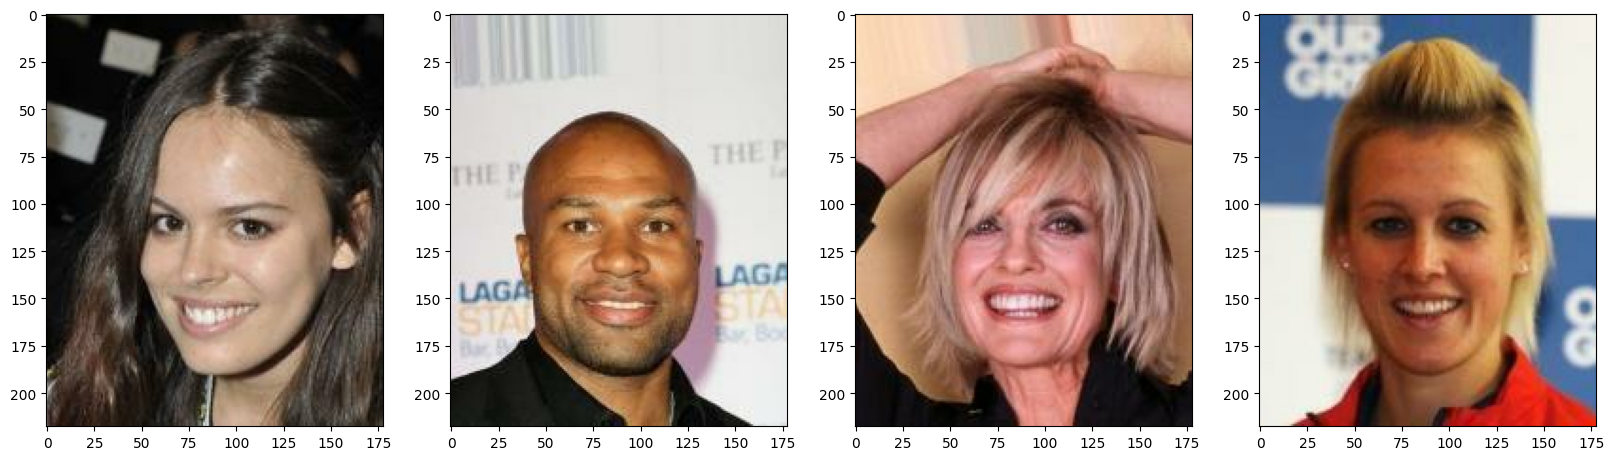

In [ ]:
fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for idx in range(4):
  batch=dataiterator.next()
  ax[idx].imshow(np.squeeze(batch["image"]))

In [ ]:
def scale_image(data):
  image=data["image"]
  image=tf.image.resize(image,[56,56])
  return image/255

In [ ]:

ds=ds.map(scale_image)
ds=ds.cache()
ds=ds.shuffle(60000)
ds=ds.batch(32)
ds=ds.prefetch(64)

In [ ]:
from tensorflow.keras import layers


In [ ]:
from keras.api._v2.keras import activations
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False,))
    assert model.output_shape == (None, 28, 28, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False,activation="tanh"))
    assert model.output_shape == (None, 56, 56, 3)

    return model

In [ ]:
generator= make_generator_model()

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [ ]:
import tensorflow as tf

In [ ]:
img123=generator(tf.random.normal([1, 100]))

In [ ]:
generator=tf.keras.models.load_model("generator2.h5")
discriminator=tf.keras.models.load_model("discriminator2.h5")

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[56, 56, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator=make_discriminator_model()

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        4864      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 28, 28, 64)        0         
                                                                 
 dropout (Dropout)           (None, 28, 28, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       204928    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 128)       0         
                                                                 
 flatten (Flatten)           (None, 25088)            

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output,fake_output):
  real_loss=cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss=cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss=real_loss+fake_loss
  return total_loss

In [ ]:
def generator_loss(fake_output):
  total_loss=cross_entropy(tf.ones_like(fake_output),fake_output)
  return total_loss

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

In [ ]:
class DCGAN(tf.keras.models.Model):
  def __init__(self,generator,discriminator,*args,**kwargs):
    super().__init__(*args,**kwargs)
    self.generator=generator
    self.discriminator=discriminator

  def compile(self,generator_optimizer,discriminator_optimizer,g_loss,d_loss,*args,**kwargs):
    super().compile(*args,**kwargs)
    self.g_opt=generator_optimizer
    self.d_opt=discriminator_optimizer
    self.g_loss=g_loss
    self.d_loss=d_loss

  def train_step(self,image):
    real_image=image
    noise=tf.random.normal([16,100])
    with tf.GradientTape() as gen_tape,  tf.GradientTape() as disc_tape:
      generated_image=self.generator(noise,training=True)
      real_output=self.discriminator(image,training=True)
      fake_output=self.discriminator(generated_image,training=True)

      gen_loss=self.g_loss(fake_output)
      disc_loss=self.d_loss(real_output,fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return  {"d_loss":gen_loss,"g_loss":disc_loss}



In [ ]:
model=DCGAN(generator,discriminator)

In [ ]:
model.compile(generator_optimizer,discriminator_optimizer,generator_loss,discriminator_loss)

In [ ]:
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
import os

In [ ]:
class ModelMoniter(Callback):
  def __init__(self,num_img=3,latent_dim=100):
    self.num_img=num_img
    self.latent_dim=latent_dim

  def on_epoch_end(self,epoch,logs=None):
    random_latent_vectors=tf.random.uniform((self.num_img,self.latent_dim,1))
    generated_images=self.model.generator(random_latent_vectors)
    generated_images+=255
    generated_images.numpy()
    for i in range(self.num_img):
      img=array_to_img(generated_images[i])
      img.save(os.path.join("images1",f"generated_img_{epoch}_{i}.png"))

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:
hist=model.fit(ds,epochs=200,callbacks=[ModelMoniter()])

Epoch 1/200
5087/5087 [==============================] - 70s 14ms/step - d_loss: 2.5083 - g_loss: 0.6527
Epoch 2/200
5087/5087 [==============================] - 71s 14ms/step - d_loss: 2.5202 - g_loss: 0.6440
Epoch 3/200
5087/5087 [==============================] - 71s 14ms/step - d_loss: 2.4904 - g_loss: 0.6782
Epoch 4/200
5087/5087 [==============================] - 71s 14ms/step - d_loss: 2.5033 - g_loss: 0.6693
Epoch 5/200
5087/5087 [==============================] - 71s 14ms/step - d_loss: 2.4505 - g_loss: 0.6786
Epoch 6/200
5087/5087 [==============================] - 71s 14ms/step - d_loss: 2.4820 - g_loss: 0.6687
Epoch 7/200
5087/5087 [==============================] - 71s 14ms/step - d_loss: 2.4508 - g_loss: 0.6872
Epoch 8/200
5087/5087 [==============================] - 71s 14ms/step - d_loss: 2.4318 - g_loss: 0.6759
Epoch 9/200
5087/5087 [==============================] - 71s 14ms/step - d_loss: 2.4991 - g_loss: 0.6543
Epoch 10/200
5087/5087 [==============================]

KeyboardInterrupt: ignored

In [ ]:

generator.save("generator5.h5")
discriminator.save("discriminator5.h5")